# Solving eigenvalue problems

You can use the `krylovevsolver` library in your Python script or Jupyter Notebook.

First, import the necessary modules.

In [1]:
from krylovevsolver import KrylovSolver   # solver
from krylovevsolver.dff import Filter, FilterGenerator  # for filter functions

# Netgen/NGSolve imports for generating mesh and visualisation purposes
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

## Weak formulation of the problem

Now, you need to derive the weak formulation of your problem. In this example, we consider the eigenvalue problem of the negative Laplace operator with Neumann boundary conditions, which is commonly used in wave equations. We aim to find eigenvalues $\omega^2$ and eigenfunctions $u$, such that:

$$
-\Delta u = \omega^2 u \quad \text{in} \ \Omega
$$
$$
\frac{\partial u}{\partial \nu} = 0 \quad \text{on} \ \partial\Omega.
$$

The weak form is given by:
$$
\int_\Omega \nabla u \cdot \nabla \varphi \, dx = \omega_h^2 \int_\Omega u \varphi \, dx.
$$

We denote the expression in the left-hand side integral as $s$, and the expression in the right-hand side integral as $m$. To implement this for your specific problem, you need to use operators supported by the `netgen` and `ngsolve` libraries. In our particular example:


In [2]:
from ngsolve.comp import ProxyFunction
from ngsolve.fem import CoefficientFunction

def s(u: ProxyFunction, v: ProxyFunction) -> CoefficientFunction:
    return grad(u)*grad(v)

def m(u: ProxyFunction, v: ProxyFunction) -> CoefficientFunction:
        return u*v

The weak formulation of the negative Laplacian eigenvalue problem is already provided in the `wave_equation` module, so you can simply import the necessary functions into your code.

In [3]:
from krylovevsolver.wave_equation import s,m 

If you want to solve another problem, you have to reformulate it and manually implement the `s` and `m` functions accordingly.



## Deriving a Discrete Filter Function (DFF)

In the next step, you need to derive an appropriate **discrete filter function** (**dff**). Choose the following parameters:

- `tau` (time-step),
- `L` (number of time-steps), 
- region of interest (`om_min` to `om_max`), where you are searching for eigenvalues.

Keep in mind that you are selecting the target interval **for the square roots of the eigenvalues**, not the eigenvalues themselves. For further guidance on parameter selection, refer to the mathematical background section.

**Note** (**CFL condition**): The square roots of all eigenvalues of your discretized FEM model **must** lie below $\omega_{\mathrm{end}} = 2/\tau$. Therefore, you should ensure that $\tau < 2/\omega$. Otherwise, the Krylov iteration will not converge to the desired eigenvalues.


In [4]:
tau = 0.0056        # controlled interval up to omega_end = 2/tau = 360
L = 100
om_min, om_max = 6, 8

Define a `FilterGenerator` object from the `krylovevsolver.dff` module with parameters: `L` (number of time-steps), `tau` (time-step), `om_min` and `om_max` (target interval) and `om_end` (end of controlled interval, recommended value: `2/tau`). Use one of methods `chebyshev()`, `l2()`, or `fourier()` to generate a `Filter` object. This is your filter function (here denoted as `alpha`). Plot the filter (the `plot()` method) to check if it has the desired shape. The obtained dff should have higher values within your target interval and be close 0 outside this interval, in the rest of the controlled region from 0 to `om_end`.

The `FilterGenerator.chebyshev()` method uses least-squares collocation on Chebyshev nodes over the interval $(0, \omega_{\mathrm{end}}^2)$. You must specify the number of nodes. If the result is unsatisfactory, you can try increasing the number of nodes. Be cautious: if your target interval is small and falls between two neighboring Chebyshev knots, you may get a constant-zero function, which is undesirable.

`FilterGenerator.l2()` method uses $L_2$-minimization with a quadrature rule. Optionally, you can specify the number of sample points in each unit interval for better accuracy.

`FilterGenerator.fourier()` method uses the inverse Fourier transform. It is the most efficient and reliable method, but it is specifically designed for the negative Laplacian eigenvalue problem only.

In [5]:
# Use one of following:
alpha = FilterGenerator(L, tau, om_min, om_max, 2/tau).fourier() # for negative Laplacian only!
alpha = FilterGenerator(L, tau, om_min, om_max, 2/tau).chebyshev(1000)  # 1000 determines number of Chebyshev nodes for collocation
alpha = FilterGenerator(L, tau, om_min, om_max, 2/tau).l2()

Note: Fourier method works for negative Laplacian problem only!
[Info]: cond(QTQ) = 2.0000000000003135, det(QTQ) = 1.577721810444296e+270
[Info]: det(X) = 4.882581193687453e+214, cond(X) = 348.2338016957765


<Axes: title={'center': 'L2 Filter on (0, 357.14285714285717): L = 100, $\\tau$ = 0.0056'}>

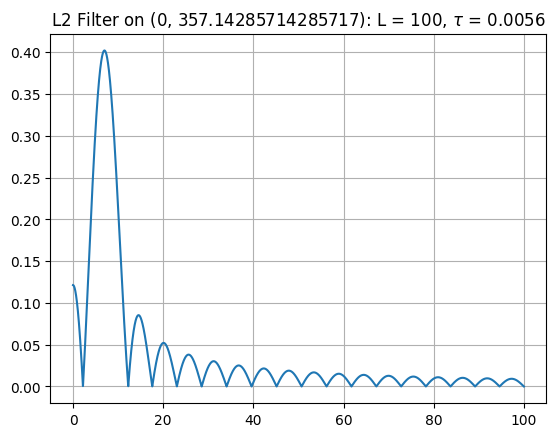

In [6]:
alpha.plot(0, 100)

This is a great example of a discrete filter function. It has significantly higher values in the target interval and values close to 0 outside the region of interest.

## Defining domain and mesh

Define the domain and generate the mesh using `netgen` and `ngsolve` packages. For more details, see [documentation](https://docu.ngsolve.org/latest/). The resulting mesh should be a `ngsolve.comp.Mesh` object.

In [14]:
geo = SplineGeometry()
p1,p2,p3,p4 = [ geo.AppendPoint(x,y) for x,y in [(0,0), (2,0), (0,1), (1,1) ] ]
geo.Append(["line", p1, p2])
geo.Append(["line", p2, p4])
geo.Append(["spline3", p4, p3, p1])

mesh = Mesh(geo.GenerateMesh(maxh=0.05)) # maxh specifies maximal cell size
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Solving the problem

Finally, you can solve your eigenvalue problem using Krylov iteration. Create a `KrylovSolver` object with your functions `s` and `m`, `mesh`, number of time-steps `L`, time-step `tau`, dff `alpha` and maximal number of Krylov iterations `m_max`.

In [21]:
solver = KrylovSolver(s, m, mesh, L, tau, alpha, m_max = 20)

Use the `discretize()` method to create the solution space (`KrylovSolver.fes`) and discretization matrices. You can just call the method without any argument and use default parameters, or specify keywords supported by `ngsolve.comp.H1`. In our example, we choose splines of order 2. Calling the `KrylovSolver.solve()` method performs the Krylov iteration.

In [22]:
solver.discretize(order=2)
solution = solver.solve()

Triangularization done after 0.03071 seconds:
	2430 degrees of freedom.
Discretization matrices computed after 1.22886 seconds.
Krylov iteration done after 26.89160 seconds.


Plot your results using `KrylovSolver.plot()` or `KrylovSolver.plot2()` method. Specify start and end of your plot. The `KrylovSolver.plot()` method scales the eigenvalue axis in $\omega$, whereas `KrylovSolver.plot2()` scales the axis in $\omega^2$. 

Each catched eigenvalue (horizontal axis) in each step (vertical axis) is marked as an "x". A vertical line of "x"s indicates proper computation of that eigenvalue. The dff is also plotted for reference.

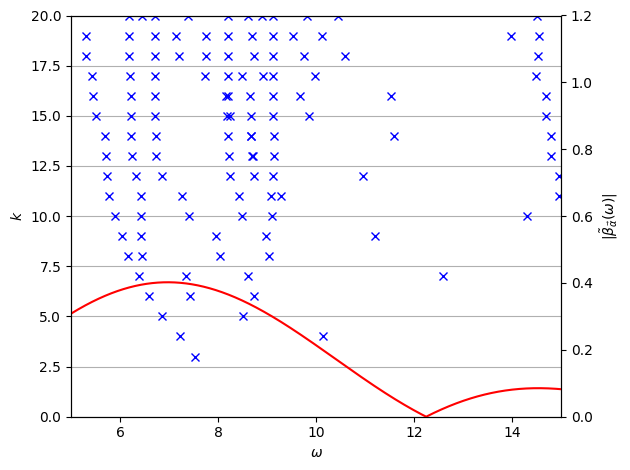

In [23]:
solver.plot(5, 15)

You can increase the number of Krylov iterations, just increasing the `m_max` value.

Krylov iteration done after 26.75535 seconds.


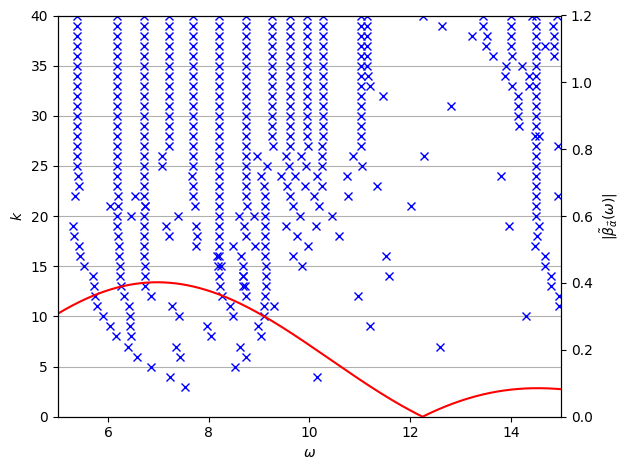

In [24]:
solver.m_max = 40
solver.plot(5, 15)

All results of the iteration are stored in a `dict`-like object of class `Results`, available through the `results` property. The key in this quasi-dictionary is the iteration number, where -1 indicates the last iteration. The value is a tuple containing two numpy arrays: `eigvals` and `eigvecs`. The first one contains all eigenvalues ($\omega^2$), second one is a matrix and contains corresponding eigenvectors in columns. `eigvecs[:,i]` is an eigenvector to `eigvals[i]`.

In [30]:
eigvals, eigvecs = solver.results[-1]
print(f"{eigvecs[:,2]} is an eigenvector to eigenvalue {eigvals[2]}.")

[ 0.00356379 -0.00798236  0.01463473 ...  0.00649149  0.0159756
 -0.00902061] is an eigenvector to eigenvalue 10419.925113995045.


Use `KrylovSolver.get_single_result()` method to get a single computed eigenpair with the eigenvalue ($\omega^2$) closest to a given value and in desired iteration (-1 refers to the last iteration). E.g. if you want to get eigenvalue, such that $\omega \approx 7$:

In [31]:
eigval, eigvec = solver.get_single_result(7*7, -1)
print(eigval)

51.86626038886238


Using `ngsolve` you can easily visualize computed eigenfunction. Just define an `ngsolve.comp.GridFunction` object, update its `vec.data` property with the computed eigenvector and use the `ngsolve.webgui.Draw()` method.

In [32]:
solution = GridFunction(solver.fes, multidim=solver.mesh.nv)
solution.vec.data += eigvec
Draw(solution, mesh, deformation=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene